# Evaluate test set performance and compare to RosettaSurf
Import the separate test set based on the dataset used in the RosettaSurf publication. Contains 200 * 20 residues.
Evaluate best model on this data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import rstoolbox as rsb

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/libconfig/config.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
#import os
from datetime import datetime
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import torchvision

In [3]:
import warnings

In [4]:
# Set seed for life
torch.manual_seed(42)
np.random.seed(42)

In [5]:
res2num = {
        "ALA": 0, 
        "ASX": 1, 
        "CYS": 2, 
        "ASP": 3, 
        "GLU": 4, 
        "PHE": 5, 
        "GLY": 6, 
        "HIS": 7,
        "ILE": 8, 
        "LYS": 9, 
        "LEU": 10, 
        "MET": 11, 
        "ASN": 12, 
        "PRO": 13, 
        "GLN": 14,
        "ARG": 15, 
        "SER": 16, 
        "THR": 17, 
        "SEC": 18, 
        "VAL": 19, 
        "TRP": 20, 
        "XAA": 21,
        "TYR": 22, 
        "GLX": 23}
    
old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", 
             "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA","TYR", "GLX"]

In [6]:
X_te = np.load('../data/dataset/test_feats.npy').astype(np.float32)
X_te = X_te.reshape(X_te.shape[0], X_te.shape[1] * X_te.shape[2])
y_te = np.load('../data/dataset/test_target.npy').astype(np.int64)

        
X_te_old = X_te
n_obs = y_te.shape[0]
nonzero_index = (~np.all(y_te == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])

# Then remove zero columns from 'y_te'
y_te = y_te[:,~np.all(y_te == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_te_scaled = scaler.fit_transform(X_te_old)
# Added theta, so now 29 instead of 28 features per point
X_te = X_te_scaled.reshape(n_obs, 50, 37)
# Get integer values from one-hot encoding
y_te_int = np.array([], dtype = np.int64)
for i in y_te:
    y_te_int = np.concatenate((y_te_int, np.nonzero(i)[0]))

# Save float and unique array_tes of y_te_int
y_te_float = y_te_int
unique_y_te = np.unique(y_te_float)
X_te_data = torch.from_numpy(X_te)
y_te_data = torch.from_numpy(y_te_int)

In [7]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.drop_layer_1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(50, 10)
        self.drop_layer_2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(500, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = self.drop_layer_1(x)
        x = F.relu(self.layer2(x))
        x = x.view(-1,10*50)
        x = self.drop_layer_2(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [8]:
model = Model(X_te.shape[2])
model.load_state_dict(torch.load('../models/model_0_2021_12_23-12:28:28_AM.pth'))
model.eval()

Model(
  (layer1): Conv1d(37, 50, kernel_size=(1,), stride=(1,))
  (drop_layer_1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
  (drop_layer_2): Dropout(p=0.8, inplace=False)
  (layer3): Linear(in_features=500, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [9]:
sns.set_style("whitegrid")

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: 

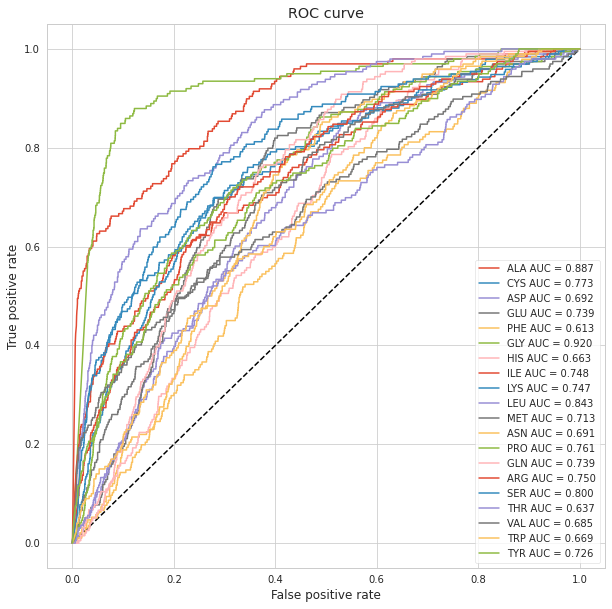

In [10]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_te_int[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_te_int))):
    
    with torch.no_grad():
        y_pre = (model(X_te_data)[y_te_int == i]).numpy()
        Y_one = Y_onehot[y_te_data == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


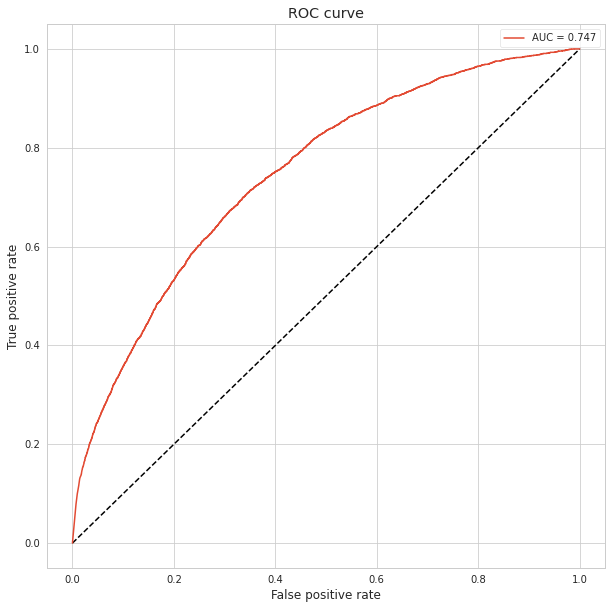

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_te_int[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_te_data).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

## Load Rosetta data, results and barplot + confusion matrix

First convert your own data to a format that allows you to compare

In [13]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_te_int).map(lambda x: num2res[x])

In [14]:
# Get one hot version of the labels, ground truth
Y_onehot = enc.fit_transform(y_te_int[:, np.newaxis]).toarray()
# Make model predictions
with torch.no_grad():
    y_pred = model(X_te_data).numpy()

# Make a one hot encoded predictions
y_pred_max = np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

# Make a series so you can make df and count
pred_rec = pd.Series([])
for i in np.arange(y_pred_max.shape[0]):
    pred_rec = pred_rec.append(pd.Series(np.all(y_pred_max[i] == Y_onehot[i])))

# Reset index and prepare to df
pred_rec.reset_index(drop=True, inplace=True)
framedict = { 'Correct': pred_rec, 'Restype': y_res_str }
dataf = pd.DataFrame(framedict)

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
# Check results
nn_rec = dataf.groupby(['Restype', 'Correct'])['Correct'].count()
correct_df = nn_rec.to_frame()

In [16]:
res_counts = y_res_str.value_counts()
res_counts = res_counts.sort_index()
correct_df = correct_df[1::2]['Correct']

In [17]:
pct_correct = []
for i in np.arange(len(correct_df)):
    pct_correct.append((correct_df[i]/res_counts[i])*100)

In [18]:
len(pct_correct)

20

In [19]:
ala_nn_bound_rec = pct_correct[0]
arg_nn_bound_rec = pct_correct[1]
asn_nn_bound_rec = pct_correct[2]
asp_nn_bound_rec = pct_correct[3]
gln_nn_bound_rec = pct_correct[5]
glu_nn_bound_rec = pct_correct[6]
gly_nn_bound_rec = pct_correct[7]
his_nn_bound_rec = pct_correct[8]
ile_nn_bound_rec = pct_correct[9]
leu_nn_bound_rec = pct_correct[10]
lys_nn_bound_rec = pct_correct[11]
met_nn_bound_rec = pct_correct[12]
phe_nn_bound_rec = pct_correct[13]
pro_nn_bound_rec = pct_correct[14]
ser_nn_bound_rec = pct_correct[15]
thr_nn_bound_rec = pct_correct[16]
trp_nn_bound_rec = pct_correct[17]
tyr_nn_bound_rec = pct_correct[18]
val_nn_bound_rec = pct_correct[19]

In [20]:
intercept = -13.79986756 
coef1 = -13.78594078
coef2 = 14.64347448

def surf_score(ss, es):
    return 1/(1+np.exp(-(intercept + coef1 * es + coef2 * ss)))

In [21]:
def calc_rec(rec_list, score, res, asc=False, ec_score=False):
    counter = 0
    print(len(rec_list))
    if ec_score:
        values = rec_list[[x for x in rec_list.columns if x.startswith(score[0]) and x.endswith(score[1])]].T
        for col in values:
            rec = values[col].sort_values(ascending=asc)
            if score[0]+'_'+res+'_'+score[1] in rec.index[:1]:
                if rec.tolist()[0] != rec.tolist()[1]:
                    counter += 1
    else:
        values = rec_list[[x for x in rec_list.columns if x.startswith(score)]].T
        for col in values:
            rec = values[col].sort_values(ascending=asc)
            if score+'_'+res in rec.index[:1]:
                if rec.tolist()[0] != rec.tolist()[1]:
                    counter += 1
    return counter

In [22]:
bound_recover_ala = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_ala.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_arg = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_arg.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asn = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_asn.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asp = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_asp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_cys = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_cys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gln = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_gln.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_glu = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_glu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gly = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_gly.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_his = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_his.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ile = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_ile.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_leu = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_leu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_lys = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_lys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_met = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_met.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_phe = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_phe.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_pro = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_pro.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ser = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_ser.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_thr = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_thr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_trp = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_trp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_tyr = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_tyr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_val = rsb.io.parse_rosetta_file('../data/bound_rosetta/recover_val.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)

In [23]:
all_bound_recover = [bound_recover_ala, bound_recover_arg, bound_recover_asn, bound_recover_asp, bound_recover_gln,
            bound_recover_glu, bound_recover_gly, bound_recover_his, bound_recover_ile, bound_recover_leu, bound_recover_lys,
            bound_recover_met, bound_recover_phe, bound_recover_pro, bound_recover_ser, bound_recover_thr, bound_recover_trp,
            bound_recover_tyr, bound_recover_val]


for ar in all_bound_recover:
    print(len(ar))

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [24]:
pd.set_option('display.max_columns', None)
bound_recover_ala

,total_score,dslf_fa13,ec_ala_avg,ec_ala_p,ec_ala_s,ec_arg_avg,ec_arg_p,ec_arg_s,ec_asn_avg,ec_asn_p,ec_asn_s,ec_asp_avg,ec_asp_p,ec_asp_s,ec_cys_avg,ec_cys_p,ec_cys_s,ec_gln_avg,ec_gln_p,ec_gln_s,ec_glu_avg,ec_glu_p,ec_glu_s,ec_gly_avg,ec_gly_p,ec_gly_s,ec_his_avg,ec_his_p,ec_his_s,ec_ile_avg,ec_ile_p,ec_ile_s,ec_leu_avg,ec_leu_p,ec_leu_s,ec_lys_avg,ec_lys_p,ec_lys_s,ec_met_avg,ec_met_p,ec_met_s,ec_phe_avg,ec_phe_p,ec_phe_s,ec_pro_avg,ec_pro_p,ec_pro_s,ec_ser_avg,ec_ser_p,ec_ser_s,ec_thr_avg,ec_thr_p,ec_thr_s,ec_trp_avg,ec_trp_p,ec_trp_s,ec_tyr_avg,ec_tyr_p,ec_tyr_s,ec_val_avg,ec_val_p,ec_val_s,epr_ala,epr_arg,epr_asn,epr_asp,epr_cys,epr_gln,epr_glu,epr_gly,epr_his,epr_ile,epr_leu,epr_lys,epr_met,epr_phe,epr_pro,epr_ser,epr_thr,epr_trp,epr_tyr,epr_val,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,sc_ala,sc_arg,sc_asn,sc_asp,sc_cys,sc_gln,sc_glu,sc_gly,sc_his,sc_ile,sc_leu,sc_lys,sc_met,sc_phe,sc_pro,sc_ser,sc_thr,sc_trp,sc_tyr,sc_val,si_ala,si_arg,si_asn,si_asp,si_cys,si_gln,si_glu,si_gly,si_his,si_ile,si_leu,si_lys,si_met,si_phe,si_pro,si_ser,si_thr,si_trp,si_tyr,si_val,yhh_planarity,description
45,-1515.767,-8.382,-0.958,-0.948,-0.968,-0.390,-0.328,-0.451,-0.908,-0.898,-0.918,-0.687,-0.668,-0.706,-0.953,-0.943,-0.962,-0.648,-0.672,-0.624,-0.269,-0.402,-0.136,-0.833,-0.856,-0.810,-0.581,-0.590,-0.572,-0.600,-0.686,-0.514,-0.516,-0.609,-0.423,-0.323,-0.246,-0.399,-0.797,-0.792,-0.802,-0.696,-0.702,-0.690,-0.054,-0.046,-0.063,-0.921,-0.913,-0.928,0.112,-0.213,0.437,-0.781,-0.767,-0.794,-0.075,-0.150,0.000,-0.824,-0.845,-0.804,-2.032,211.557,21.654,13.809,26.980,157.684,79.888,0.002,450.195,60.729,189.130,127.046,118.171,606.612,66.762,-0.232,19.018,652.054,686.262,62.196,-3645.265,668.603,-887.082,6.736,102.348,565.534,2011.521,-115.664,-285.718,-91.742,-72.490,-68.175,98.880,-154.223,6.174,61.558,290.920,0.603,0.613,0.605,0.605,0.603,0.610,0.608,0.593,0.612,0.614,0.617,0.610,0.599,0.611,0.607,0.603,0.597,0.608,0.588,0.607,0.999,0.759,0.978,0.983,0.992,0.856,0.846,0.658,0.867,0.792,0.761,0.724,0.669,0.804,0.675,0.992,0.641,0.716,0.088,0.940,0.698,2R0K_HL_A
49,-759.987,0.000,-0.975,-0.978,-0.971,-0.493,-0.499,-0.487,-0.526,-0.616,-0.436,-0.568,-0.624,-0.512,-0.927,-0.948,-0.906,-0.682,-0.657,-0.708,-0.570,-0.542,-0.598,-0.840,-0.868,-0.812,-0.439,-0.509,-0.369,-0.653,-0.678,-0.628,-0.910,-0.939,-0.882,-0.411,-0.497,-0.324,-0.733,-0.682,-0.783,-0.445,-0.615,-0.276,-0.731,-0.817,-0.646,-0.834,-0.896,-0.773,-0.798,-0.755,-0.841,-0.808,-0.854,-0.762,-0.646,-0.740,-0.553,-0.708,-0.730,-0.686,-2.249,380.145,188.255,120.853,33.699,172.476,148.202,-0.574,526.498,252.689,203.743,295.565,293.468,645.178,140.965,-0.062,104.135,421.375,702.829,123.085,-2364.042,474.703,-612.773,4.434,81.524,524.573,1545.678,-91.453,-69.014,-78.495,-146.208,-64.983,31.386,-83.078,2.279,-22.776,108.020,0.665,0.658,0.637,0.638,0.667,0.642,0.643,0.655,0.628,0.632,0.671,0.629,0.630,0.629,0.667,0.666,0.659,0.673,0.626,0.644,0.992,0.539,0.535,0.555,0.979,0.640,0.630,0.799,0.400,0.393,0.826,0.621,0.620,0.374,0.956,0.988,0.795,0.636,0.359,0.667,0.238,1YRU_A_B
145,-433.481,0.000,-0.992,-0.996,-0.988,-0.276,-0.317,-0.235,-0.027,-0.114,0.061,-0.231,-0.219,-0.242,-0.381,-0.640,-0.122,0.075,0.152,-0.002,-0.667,-0.808,-0.526,-0.117,-0.137,-0.097,-0.545,-0.634,-0.456,-0.596,-0.767,-0.425,-0.751,-0.802,-0.699,-0.790,-0.748,-0.832,-0.110,-0.256,0.035,-0.668,-0.702,-0.635,-0.235,-0.202,-0.268,-0.576,-0.780,-0.371,-0.168,-0.423,0.087,-0.619,-0.685,-0.552,-0.727,-0.775,-0.680,-0.579,-0.760,-0.398,-2.790,187.586,22.689,8.921,21.814,46.335,25.347,-1.529,406.412,122.458,115.749,100.001,54.941,596.401,13.913,-2.303,43.418,867.299,640.530,62.329,-975.207,191.584,-293.788,1.902,29.877,216.554,546.598,-26.331,-104.119,-29.891,-20.063,-11.437,7.491,-48.801,0.546,9.905,71.618,0.651,0.652,0.656,0.659,0.655,0.684,0.652,0.622,0.667,0.644,0.670,0.676,0.670,0.681,0.664,0.6

### Compute combined surface score

In [25]:
for ar in all_bound_recover:
    ar['sses_ala'] = ar.apply(lambda row: surf_score(row['si_ala'], row['ec_ala_avg']), axis=1)
    ar['sses_arg'] = ar.apply(lambda row: surf_score(row['si_arg'], row['ec_arg_avg']), axis=1)
    ar['sses_asn'] = ar.apply(lambda row: surf_score(row['si_asn'], row['ec_asn_avg']), axis=1)
    ar['sses_asp'] = ar.apply(lambda row: surf_score(row['si_asp'], row['ec_asp_avg']), axis=1)
    ar['sses_gln'] = ar.apply(lambda row: surf_score(row['si_gln'], row['ec_gln_avg']), axis=1)
    ar['sses_glu'] = ar.apply(lambda row: surf_score(row['si_glu'], row['ec_glu_avg']), axis=1)
    ar['sses_gly'] = ar.apply(lambda row: surf_score(row['si_gly'], row['ec_gly_avg']), axis=1)
    ar['sses_his'] = ar.apply(lambda row: surf_score(row['si_his'], row['ec_his_avg']), axis=1)
    ar['sses_ile'] = ar.apply(lambda row: surf_score(row['si_ile'], row['ec_ile_avg']), axis=1)
    ar['sses_leu'] = ar.apply(lambda row: surf_score(row['si_leu'], row['ec_leu_avg']), axis=1)
    ar['sses_lys'] = ar.apply(lambda row: surf_score(row['si_lys'], row['ec_lys_avg']), axis=1)
    ar['sses_met'] = ar.apply(lambda row: surf_score(row['si_met'], row['ec_met_avg']), axis=1)
    ar['sses_phe'] = ar.apply(lambda row: surf_score(row['si_phe'], row['ec_phe_avg']), axis=1)
    ar['sses_pro'] = ar.apply(lambda row: surf_score(row['si_pro'], row['ec_pro_avg']), axis=1)
    ar['sses_ser'] = ar.apply(lambda row: surf_score(row['si_ser'], row['ec_ser_avg']), axis=1)
    ar['sses_thr'] = ar.apply(lambda row: surf_score(row['si_thr'], row['ec_thr_avg']), axis=1)
    ar['sses_trp'] = ar.apply(lambda row: surf_score(row['si_trp'], row['ec_trp_avg']), axis=1)
    ar['sses_tyr'] = ar.apply(lambda row: surf_score(row['si_tyr'], row['ec_tyr_avg']), axis=1)
    ar['sses_val'] = ar.apply(lambda row: surf_score(row['si_val'], row['ec_val_avg']), axis=1)

### Compute how often the correct amino acid was recovered with the different scoring functions

In [26]:
ala_si_bound_rec = calc_rec(bound_recover_ala.head(100), 'si', 'ala')
ala_sses_bound_rec = calc_rec(bound_recover_ala.head(100), 'sses', 'ala')
ala_es_bound_rec = calc_rec(bound_recover_ala.head(100), ['ec', 'avg'], 'ala', ec_score=True, asc=True)
ala_epr_bound_rec = calc_rec(bound_recover_ala.head(100), 'epr', 'ala', asc=True)
#ala_nn_bound_rec = calc_rec(bound_recover_ala.head(100), 'nn', 'ala', asc=True)

arg_si_bound_rec = calc_rec(bound_recover_arg.head(100), 'si', 'arg')
arg_sses_bound_rec = calc_rec(bound_recover_arg.head(100), 'sses', 'arg')
arg_es_bound_rec = calc_rec(bound_recover_arg.head(100), ['ec', 'avg'], 'arg', ec_score=True, asc=True)
arg_epr_bound_rec = calc_rec(bound_recover_arg.head(100), 'epr', 'arg', asc=True)

asn_si_bound_rec = calc_rec(bound_recover_asn.head(100), 'si', 'asn')
asn_sses_bound_rec = calc_rec(bound_recover_asn.head(100), 'sses', 'asn')
asn_es_bound_rec = calc_rec(bound_recover_asn.head(100), ['ec', 'avg'], 'asn', ec_score=True, asc=True)
asn_epr_bound_rec = calc_rec(bound_recover_asn.head(100), 'epr', 'asn', asc=True)

asp_si_bound_rec = calc_rec(bound_recover_asp.head(100), 'si', 'asp')
asp_sses_bound_rec = calc_rec(bound_recover_asp.head(100), 'sses', 'asp')
asp_es_bound_rec = calc_rec(bound_recover_asp.head(100), ['ec', 'avg'], 'asp', ec_score=True, asc=True)
asp_epr_bound_rec = calc_rec(bound_recover_asp.head(100), 'epr', 'asp', asc=True)

gln_si_bound_rec = calc_rec(bound_recover_gln.head(100), 'si', 'gln')
gln_sses_bound_rec = calc_rec(bound_recover_gln.head(100), 'sses', 'gln')
gln_es_bound_rec = calc_rec(bound_recover_gln.head(100), ['ec', 'avg'], 'gln', ec_score=True, asc=True)
gln_epr_bound_rec = calc_rec(bound_recover_gln.head(100), 'epr', 'gln', asc=True)

glu_si_bound_rec = calc_rec(bound_recover_glu.head(100), 'si', 'glu')
glu_sses_bound_rec = calc_rec(bound_recover_glu.head(100), 'sses', 'glu')
glu_es_bound_rec = calc_rec(bound_recover_glu.head(100), ['ec', 'avg'], 'glu', ec_score=True, asc=True)
glu_epr_bound_rec = calc_rec(bound_recover_glu.head(100), 'epr', 'glu', asc=True)

gly_si_bound_rec = calc_rec(bound_recover_gly.head(100), 'si', 'gly')
gly_sses_bound_rec = calc_rec(bound_recover_gly.head(100), 'sses', 'gly')
gly_es_bound_rec = calc_rec(bound_recover_gly.head(100), ['ec', 'avg'], 'gly', ec_score=True, asc=True)
gly_epr_bound_rec = calc_rec(bound_recover_gly.head(100), 'epr', 'gly', asc=True)

his_si_bound_rec = calc_rec(bound_recover_his.head(100), 'si', 'his')
his_sses_bound_rec = calc_rec(bound_recover_his.head(100), 'sses', 'his')
his_es_bound_rec = calc_rec(bound_recover_his.head(100), ['ec', 'avg'], 'his', ec_score=True, asc=True)
his_epr_bound_rec = calc_rec(bound_recover_his.head(100), 'epr', 'his', asc=True)

ile_si_bound_rec = calc_rec(bound_recover_ile.head(100), 'si', 'ile')
ile_sses_bound_rec = calc_rec(bound_recover_ile.head(100), 'sses', 'ile')
ile_es_bound_rec = calc_rec(bound_recover_ile.head(100), ['ec', 'avg'], 'ile', ec_score=True, asc=True)
ile_epr_bound_rec = calc_rec(bound_recover_ile.head(100), 'epr', 'ile', asc=True)

leu_si_bound_rec = calc_rec(bound_recover_leu.head(100), 'si', 'leu')
leu_sses_bound_rec = calc_rec(bound_recover_leu.head(100), 'sses', 'leu')
leu_es_bound_rec = calc_rec(bound_recover_leu.head(100), ['ec', 'avg'], 'leu', ec_score=True, asc=True)
leu_epr_bound_rec = calc_rec(bound_recover_leu.head(100), 'epr', 'leu', asc=True)

lys_si_bound_rec = calc_rec(bound_recover_lys.head(100), 'si', 'lys')
lys_sses_bound_rec = calc_rec(bound_recover_lys.head(100), 'sses', 'lys')
lys_es_bound_rec = calc_rec(bound_recover_lys.head(100), ['ec', 'avg'], 'lys', ec_score=True, asc=True)
lys_epr_bound_rec = calc_rec(bound_recover_lys.head(100), 'epr', 'lys', asc=True)

met_si_bound_rec = calc_rec(bound_recover_met.head(100), 'si', 'met')
met_sses_bound_rec = calc_rec(bound_recover_met.head(100), 'sses', 'met')
met_es_bound_rec = calc_rec(bound_recover_met.head(100), ['ec', 'avg'], 'met', ec_score=True, asc=True)
met_epr_bound_rec = calc_rec(bound_recover_met.head(100), 'epr', 'met', asc=True)

phe_si_bound_rec = calc_rec(bound_recover_phe.head(100), 'si', 'phe')
phe_sses_bound_rec = calc_rec(bound_recover_phe.head(100), 'sses', 'phe')
phe_es_bound_rec = calc_rec(bound_recover_phe.head(100), ['ec', 'avg'], 'phe', ec_score=True, asc=True)
phe_epr_bound_rec = calc_rec(bound_recover_phe.head(100), 'epr', 'phe', asc=True)

pro_si_bound_rec = calc_rec(bound_recover_pro.head(100), 'si', 'pro')
pro_sses_bound_rec = calc_rec(bound_recover_pro.head(100), 'sses', 'pro')
pro_es_bound_rec = calc_rec(bound_recover_pro.head(100), ['ec', 'avg'], 'pro', ec_score=True, asc=True)
pro_epr_bound_rec = calc_rec(bound_recover_pro.head(100), 'epr', 'pro', asc=True)

ser_si_bound_rec = calc_rec(bound_recover_ser.head(100), 'si', 'ser')
ser_sses_bound_rec = calc_rec(bound_recover_ser.head(100), 'sses', 'ser')
ser_es_bound_rec = calc_rec(bound_recover_ser.head(100), ['ec', 'avg'], 'ser', ec_score=True, asc=True)
ser_epr_bound_rec = calc_rec(bound_recover_ser.head(100), 'epr', 'ser', asc=True)

thr_si_bound_rec = calc_rec(bound_recover_thr.head(100), 'si', 'thr')
thr_sses_bound_rec = calc_rec(bound_recover_thr.head(100), 'sses', 'thr')
thr_es_bound_rec = calc_rec(bound_recover_thr.head(100), ['ec', 'avg'], 'thr', ec_score=True, asc=True)
thr_epr_bound_rec = calc_rec(bound_recover_thr.head(100), 'epr', 'thr', asc=True)

trp_si_bound_rec = calc_rec(bound_recover_trp.head(100), 'si', 'trp')
trp_sses_bound_rec = calc_rec(bound_recover_trp.head(100), 'sses', 'trp')
trp_es_bound_rec = calc_rec(bound_recover_trp.head(100), ['ec', 'avg'], 'trp', ec_score=True, asc=True)
trp_epr_bound_rec = calc_rec(bound_recover_trp.head(100), 'epr', 'trp', asc=True)

tyr_si_bound_rec = calc_rec(bound_recover_tyr.head(100), 'si', 'tyr')
tyr_sses_bound_rec = calc_rec(bound_recover_tyr.head(100), 'sses', 'tyr')
tyr_es_bound_rec = calc_rec(bound_recover_tyr.head(100), ['ec', 'avg'], 'tyr', ec_score=True, asc=True)
tyr_epr_bound_rec = calc_rec(bound_recover_tyr.head(100), 'epr', 'tyr', asc=True)

val_si_bound_rec = calc_rec(bound_recover_val.head(100), 'si', 'val')
val_sses_bound_rec = calc_rec(bound_recover_val.head(100), 'sses', 'val')
val_es_bound_rec = calc_rec(bound_recover_val.head(100), ['ec', 'avg'], 'val', ec_score=True, asc=True)
val_epr_bound_rec = calc_rec(bound_recover_val.head(100), 'epr', 'val', asc=True)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [27]:
all_single_bound_recs_si = [ala_si_bound_rec ,
arg_si_bound_rec ,
asn_si_bound_rec ,
asp_si_bound_rec ,
gln_si_bound_rec ,
glu_si_bound_rec ,
gly_si_bound_rec ,
his_si_bound_rec ,
ile_si_bound_rec ,
leu_si_bound_rec ,
lys_si_bound_rec ,
met_si_bound_rec ,
phe_si_bound_rec ,
pro_si_bound_rec ,
ser_si_bound_rec ,
thr_si_bound_rec ,
trp_si_bound_rec ,
tyr_si_bound_rec ,
val_si_bound_rec ]

all_single_bound_recs_es = [ala_es_bound_rec ,
arg_es_bound_rec ,
asn_es_bound_rec ,
asp_es_bound_rec ,
gln_es_bound_rec ,
glu_es_bound_rec ,
gly_es_bound_rec ,
his_es_bound_rec ,
ile_es_bound_rec ,
leu_es_bound_rec ,
lys_es_bound_rec ,
met_es_bound_rec ,
phe_es_bound_rec ,
pro_es_bound_rec ,
ser_es_bound_rec ,
thr_es_bound_rec ,
trp_es_bound_rec ,
tyr_es_bound_rec ,
val_es_bound_rec ]

all_single_bound_recs_sses = [ala_sses_bound_rec ,
arg_sses_bound_rec ,
asn_sses_bound_rec ,
asp_sses_bound_rec ,
gln_sses_bound_rec ,
glu_sses_bound_rec ,
gly_sses_bound_rec ,
his_sses_bound_rec ,
ile_sses_bound_rec ,
leu_sses_bound_rec ,
lys_sses_bound_rec ,
met_sses_bound_rec ,
phe_sses_bound_rec ,
pro_sses_bound_rec ,
ser_sses_bound_rec ,
thr_sses_bound_rec ,
trp_sses_bound_rec ,
tyr_sses_bound_rec ,
val_sses_bound_rec ]

all_single_bound_recs_epr = [
ala_epr_bound_rec ,
arg_epr_bound_rec ,
asn_epr_bound_rec ,
asp_epr_bound_rec ,
gln_epr_bound_rec ,
glu_epr_bound_rec ,
gly_epr_bound_rec ,
his_epr_bound_rec ,
ile_epr_bound_rec ,
leu_epr_bound_rec ,
lys_epr_bound_rec ,
met_epr_bound_rec ,
phe_epr_bound_rec ,
pro_epr_bound_rec ,
ser_epr_bound_rec ,
thr_epr_bound_rec ,
trp_epr_bound_rec ,
tyr_epr_bound_rec ,
val_epr_bound_rec ]

all_single_bound_recs_nn = [
ala_nn_bound_rec ,
arg_nn_bound_rec ,
asn_nn_bound_rec ,
asp_nn_bound_rec ,
gln_nn_bound_rec ,
glu_nn_bound_rec ,
gly_nn_bound_rec ,
his_nn_bound_rec ,
ile_nn_bound_rec ,
leu_nn_bound_rec ,
lys_nn_bound_rec ,
met_nn_bound_rec ,
phe_nn_bound_rec ,
pro_nn_bound_rec ,
ser_nn_bound_rec ,
thr_nn_bound_rec ,
trp_nn_bound_rec ,
tyr_nn_bound_rec ,
val_nn_bound_rec ]


aas = ['Ala', 'Arg', 'Asn', 'Asp', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 
       'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

In [28]:
all_single_bound_recs = pd.DataFrame({'count': all_single_bound_recs_epr + all_single_bound_recs_nn,
                                'aas': aas + aas , 
                                'variant': len(all_single_bound_recs_epr)*['epr'] + len(all_single_bound_recs_nn)*['nn']})


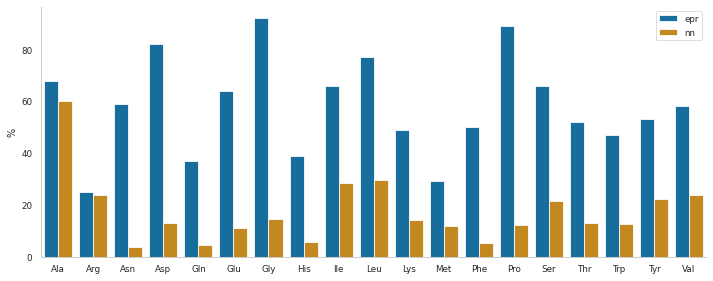

In [29]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(10, 4)

ax = plt.subplot2grid((1, 1), (0, 0))
ax.grid(False)
sns.despine()

ax = sns.barplot(x='aas', y='count', hue='variant', data=all_single_bound_recs, palette=sns.color_palette("colorblind"))
plt.xlabel("")
plt.ylabel("%")
plt.legend(title='')

plt.tight_layout(w_pad=0)

In [30]:
unbiased_bound_single_rec_heatmap = pd.DataFrame(index=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'],
                      columns=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'])

In [31]:
aa_names =['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val']
for ar in range(len(all_bound_recover)):
    tmp_list = []
    for c in sorted(all_bound_recover[ar].columns):
        if c.startswith('sses_') and not c.startswith('sses_cys'):
            tmp_list.append(all_bound_recover[ar][c].mean())
    unbiased_bound_single_rec_heatmap[aa_names[ar]] = tmp_list

In [32]:
unbiased_bound_single_rec_heatmap

,ala,arg,asn,asp,gln,glu,gly,his,ile,leu,lys,met,phe,pro,ser,thr,trp,tyr,val
ala,0.999988,0.483197,0.616006,0.710516,0.415097,0.411984,0.862591,0.443741,0.518273,0.485906,0.446780,0.595849,0.552850,0.778993,0.938760,0.731367,0.481496,0.376941,0.697631
arg,0.451329,0.903694,0.312062,0.072564,0.227148,0.082670,0.655908,0.220532,0.291785,0.341197,0.333557,0.345876,0.314174,0.178212,0.336787,0.295001,0.419765,0.364941,0.309464
asn,0.728402,0.399067,0.982558,0.812282,0.385656,0.332463,0.682302,0.622438,0.531412,0.810506,0.393070,0.428114,0.711529,0.401918,0.701548,0.550866,0.510645,0.473567,0.437478
asp,0.726627,0.104623,0.880943,0.990018,0.265050,0.354787,0.444591,0.723850,0.338362,0.763557,0.122512,0.436931,0.890498,0.331119,0.732178,0.492143,0.618927,0.517303,0.324472
gln,0.600031,0.343392,0.352487,0.285920,0.971933,0.786440,0.434214,0.363690,0.436050,0.426193,0.458780,0.805217,0.388164,0.229827,0.418318,0.472092,0.351379,0.222570,0.387703
glu,0.508385,0.093751,0.291789,0.354479,0.750408,0.998698,0.304569,0.433353,0.389841,0.389623,0.248515,0.780761,0.530673,0.284560,0.384163,0.403301,0.448820,0.239906,0.302091
gly,0.743480,0.486188,0.416252,0.239729,0.202711,0.070287,0.999999,0.353543,0.192102,0.197470,0.238675,0.279067,0.333132,0.369533,0.619096,0.436832,0.318194,0.296484,0.280971
his,0.547315,0.178174,0.463720,0.546290,0.297401,0.340378,0.594075,0.976329,0.348678,0.591903,0.303089,0.414636,0.991624,0.242199,0.480388,0.382825,0.763518,0.809810,0.335124
ile,0.566977,0.335994,0.423336,0.316698,0.271590,0.308357,0.426305,0.254146,0.999996,0.542387,0.305669,0.548308,0.378825,0.355638,0.632672,0.799554,0.311802,0.281576,0.897463
leu,0.598635,0.381154,0.598172,0.519175,0.348512,0.455323,0.520567,0.487308,0.569279,0.999999,0.363009,0.546123,0.659987,0.267156,0.542631,0.488278,0.414934,0.436891,0.502320


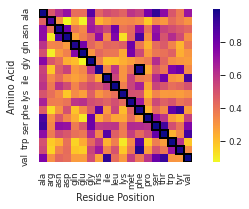

In [33]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.heatmap(unbiased_bound_single_rec_heatmap ,annot=False, fmt=".3f", square=True, ax=ax, cmap="plasma_r", 
                 linewidths=0)

row_max = unbiased_bound_single_rec_heatmap.idxmax(axis=1)
for row, index in enumerate(aa_names):
    position = unbiased_bound_single_rec_heatmap.columns.get_loc(row_max[index])
    ax.add_patch(matplotlib.patches.Rectangle((position, row),1,1, fill=False, edgecolor='black', lw=2))

plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")
plt.tight_layout()

## Similar heatmap for our method

In [34]:
Y_onehot = enc.fit_transform(y_te_int[:, np.newaxis]).toarray()
with torch.no_grad():
    y_pred = model(X_te_data).numpy()

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [35]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [36]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

In [38]:
norm_cm = cm/cm.sum(axis =1,keepdims=True)

In [39]:
norm_cm = norm_cm*100

In [40]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(10, 8))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1)
    ax = sns.heatmap(data, annot=False, cmap="plasma_r", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_yticklabels(labels, rotation = 45)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

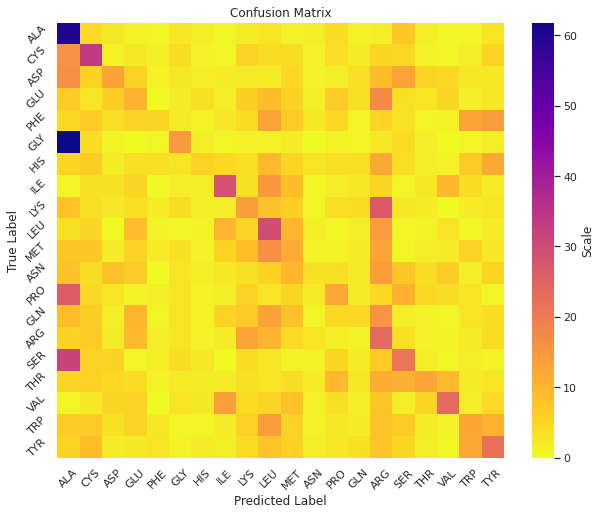

In [41]:
plot_confusion_matrix(norm_cm, names)